# Identificación de Retinopatía Diabética con Arquitectura de Aswin Shriram Thiagarajan et al

Paper: Aswin Shriram Thiagarajan et al., / Journal of Computer Science 2020, 16 (3): 305.313 

__DOI: 10.3844/jcssp.2020.305.313__

In [26]:
from sklearn.metrics import classification_report

from tesis_lib.nn.thiagarajan import Thiagarajan
from tesis_lib.io.hdf5datasetgenerator import HDF5DatasetGenerator
from tesis_lib.datasets.rosenbrock_loader import RosenbrockLoader
from tesis_lib.callbacks.trainingmonitor import TrainingMonitor
from tesis_lib.preprocessing.imagetoarrayprocessor import ImageToArrayPreprocessor
from tesis_lib.preprocessing.aspectawareprocessor import AspectAwareProcessor
from tesis_lib.preprocessing.patchpreprocessor import PatchPreprocessor
from tesis_lib.preprocessing.meanpreprocessor import MeanPreprocessor
from tesis_lib.preprocessing.simplepreprocessor import SimpleProcessor

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import progressbar
import json
import cv2
import os

In [27]:
TIME_STAMP = datetime.today().strftime("%d_%m_%Y_%H_%M")

In [28]:
DATASET_PATH = './DB'

FILENAME = f'ident_thiagarajan_{TIME_STAMP}'

MODEL_OUT_PATH = f'./models/{FILENAME}.h5'
OUTPUT_PATH = F'./output/{FILENAME}'

BATCH_SIZE = 32
EPOCHS = 75
IM_SIZE = 256
NUM_CLASSES = 2

LEARNING_RATE = 1e-3
DROP_FACTOR = 0.10
DROP_EPOCHS = 10

In [29]:
report_dict = {
    'learning-rate' : str(LEARNING_RATE),
    'epochs': EPOCHS,
    'image-size': IM_SIZE,
    'batch-size': BATCH_SIZE,
    'data': {}
}

In [30]:
aug = ImageDataGenerator(
    rotation_range=25, 
    shear_range=0.20, 
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest')

report_dict['augmentation'] = {
    'rotation_range': str(aug.rotation_range),
    'shear_range': str(aug.shear_range),
    'zoom_range': str(aug.zoom_range),
    'width_shift_range': str(aug.width_shift_range),
    'height_shift_range': str(aug.height_shift_range),
    'horizontal_flip': str(aug.horizontal_flip),
    'fill_mode': str(aug.fill_mode),
}

In [31]:
means = json.loads(open('./DB/hdf5/diat_ret.json').read())

sp = SimpleProcessor(IM_SIZE, IM_SIZE)
pp = PatchPreprocessor(IM_SIZE,IM_SIZE)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

In [32]:
trainGen = HDF5DatasetGenerator(
    'DB/hdf5/Training.hdf5',
    batchSize=BATCH_SIZE,
    aug=aug,
    preprocessors=[pp, mp, iap],
    classes=NUM_CLASSES
)

report_dict['data']['trainGen'] = {
    'preprocessors': [
        'PatchPreprocessor',
        'MeanPreprocessor',
        'ImageToArrayPreprocessor'
    ]
}

valGen = HDF5DatasetGenerator(
    'DB/hdf5/Validation.hdf5',
    batchSize=BATCH_SIZE,
    aug=aug,
    preprocessors=[sp, mp, iap],
    classes=NUM_CLASSES
)

report_dict['data']['valGen'] = {
    'preprocessors': [
        'SimpleProcessor',
        'MeanPreprocessor',
        'ImageToArrayPreprocessor'
    ]
}

In [33]:
def step_decay(epoch):
    initAlpha = LEARNING_RATE
    factor = DROP_FACTOR
    dropEvery = DROP_EPOCHS

    alpha = initAlpha * (factor ** np.floor((1+epoch) / dropEvery))

    return float(alpha)

In [34]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

In [35]:
print("[INFO] Compiling model ...")


opt = Adam(lr=LEARNING_RATE)

model = Thiagarajan.build(
    width= IM_SIZE,
    height= IM_SIZE,
    depth= 3,
    classes= NUM_CLASSES
)

model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

monitor_path = os.path.sep.join([
    OUTPUT_PATH,
    f"{FILENAME}.jpg"
])

checkpoint = ModelCheckpoint(
    MODEL_OUT_PATH, 
    monitor="val_loss", 
    mode='min', 
    save_best_only=True,
    verbose=1)

callbacks = [
    checkpoint,
    # LearningRateScheduler(step_decay),
    TrainingMonitor(monitor_path)
]

display(model.summary())

print(f"[INFO] training model ...")

H = model.fit(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages // BATCH_SIZE,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages // BATCH_SIZE,
    epochs= EPOCHS,
    max_queue_size=10,
    callbacks=callbacks,
    verbose=1
)

[INFO] Compiling model ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           

None

[INFO] training model ...
Epoch 1/75
14/14 [==============================] - ETA: 0s - loss: 1.6448 - accuracy: 0.6161
Epoch 1: val_loss improved from inf to 6.11082, saving model to ./models/ident_thiagarajan_30_01_2023_14_30.h5
14/14 [==============================] - 18s 1s/step - loss: 1.6448 - accuracy: 0.6161 - val_loss: 6.1108 - val_accuracy: 0.2292
Epoch 2/75
14/14 [==============================] - ETA: 0s - loss: 1.5230 - accuracy: 0.6555
Epoch 2: val_loss improved from 6.11082 to 3.73057, saving model to ./models/ident_thiagarajan_30_01_2023_14_30.h5
14/14 [==============================] - 16s 1s/step - loss: 1.5230 - accuracy: 0.6555 - val_loss: 3.7306 - val_accuracy: 0.3646
Epoch 3/75
14/14 [==============================] - ETA: 0s - loss: 1.4490 - accuracy: 0.6914
Epoch 3: val_loss did not improve from 3.73057
14/14 [==============================] - 15s 1s/step - loss: 1.4490 - accuracy: 0.6914 - val_loss: 3.7755 - val_accuracy: 0.3542
Epoch 4/75
14/14 [==============

In [36]:
report_dict['optimizer'] = {k:str(v) for k,v in opt.get_config().items()}
report_dict['checkpoint'] = {
    'monitor': checkpoint.monitor,
    'best-loss': str(checkpoint.best)
}

trainGen.close()
valGen.close()

## Making predictions and evaluating the model

In [37]:
report_dict['data']['testGen'] = {
    'preprocessors': [
		'SimpleProcessor',
		'MeanPreprocessor',
		'ImageToArrayPreprocessor'
	]
}

In [49]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    MATRIX_PATH = os.path.sep.join([OUTPUT_PATH, f'cm-{FILENAME}.jpg'])
    plt.savefig(MATRIX_PATH)
    plt.show()

[INFO] loading model...
[INFO] predicting on test data (no crops)...
3/3 [==============================] - 1s 236ms/step
[INFO] rank-1: 83.33%


[INFO] Calculating Confusion Matrix
Confusion matrix, without normalization
[[76  2]
 [14  4]]


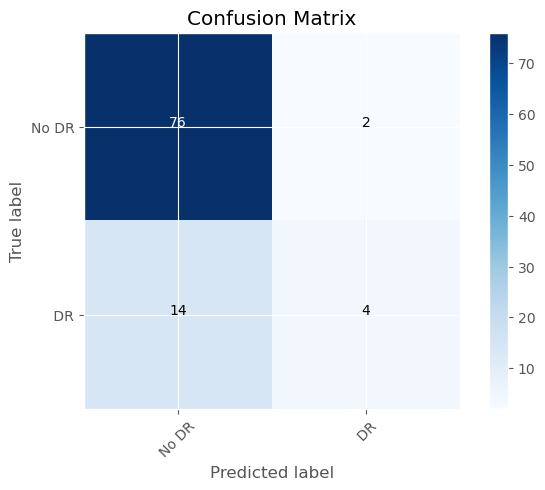

[INFO] Generating the Classification Report
              precision    recall  f1-score   support

       No DR       0.84      0.97      0.90        78
          DR       0.67      0.22      0.33        18

    accuracy                           0.83        96
   macro avg       0.76      0.60      0.62        96
weighted avg       0.81      0.83      0.80        96

[INFO] Calculating the class likelihood ratios
|	Class 0: 8.67
|	Class 1: 0.80


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, class_likelihood_ratios

# from tesis_lib.io.hdf5datasetgenerator import HDF5DatasetGenerator
# from tesis_lib.preprocessing.simplepreprocessor import SimpleProcessor
# from tesis_lib.preprocessing.meanpreprocessor import MeanPreprocessor
# from tesis_lib.preprocessing.croppreprocessor import CropPreprocessor
# from tesis_lib.preprocessing.imagetoarrayprocessor import ImageToArrayPreprocessor

from tesis_lib.utils.ranked import rank5_accuracy
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
# import numpy as np
# import progressbar
# import json

BATCH_SIZE = 32
IM_SIZE = 256
NUM_CLASSES = 2

means = json.loads(open('./DB/hdf5/diat_ret.json').read())

sp = SimpleProcessor(IM_SIZE, IM_SIZE)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

# load the pretrained network
print("[INFO] loading model...")
model = load_model('models/ident_thiagarajan_30_01_2023_13_40.h5')

# initialize the testing dataset generator, then make predictions on
# the testing data
print("[INFO] predicting on test data (no crops)...")

testGen = HDF5DatasetGenerator(
	'./DB/hdf5/Testing.hdf5',
	BATCH_SIZE,
	preprocessors=[sp, mp, iap],
	classes=NUM_CLASSES)

predictions = model.predict(
	testGen.generator(),
	steps=testGen.numImages // BATCH_SIZE, 
	max_queue_size=10)

trueLabels = list(testGen.db["labels"])
predictedLabels = list(predictions.argmax(axis=1))

# compute the rank-1 and rank-5 accuracies
(rank1, _) = rank5_accuracy(predictions, trueLabels)
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))

testGen.close()

print("\n\n[INFO] Calculating Confusion Matrix")
cm = confusion_matrix(
    y_true = trueLabels[:96],
    y_pred = predictedLabels
)
plot_confusion_matrix(cm, ['No DR',' DR'], False, "Confusion Matrix")

print("[INFO] Generating the Classification Report")
print(classification_report(
	y_true = trueLabels[:96],
	y_pred = predictedLabels,
	target_names= ['No DR', 'DR']
))

print("[INFO] Calculating the class likelihood ratios")

ratios = class_likelihood_ratios(
	y_true = trueLabels[:96],
	y_pred = predictedLabels
)

for c,r in enumerate(ratios):
	print("|\tClass {}: {:.2f}".format(c, r))

In [ ]:
# Saving a report of the parameters used for training

JSON_PATH = os.path.sep.join([OUTPUT_PATH, f'{FILENAME}.json'])

with open(JSON_PATH, "w") as f:
    f.write(json.dumps(report_dict, indent=1))